In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt.cla import CLA
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import yfinance as yf

sys.path.append('..')#, '../pypfopt_local/pypfopt'])
from util.batcher import Batcher
#from util.stock_loader import Loader

In [3]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 8, 26), datetime.date(2022, 8, 24))

In [4]:
sharpes = pd.read_csv('sharpes.csv')
sharpes.head()

,stock,sharpe
0,ASAN,4.146624
1,efc,3.530101
2,stry,3.398456
3,lly,3.048137
4,eve,2.531150


<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq listings</a>

In [7]:
#KEEP_TOP_N = 50
sym = (
    'arlc afac arna arcc argu arhs aris aria arba ards ram rams ariz '
    'arkr armh aaci armo aogo artx ara arqq arry arrs arvl arow arro '
    'arwm banx arwr arrw artg artl arte aip atsn artc arta aacq artw '
    'arvn astt asbb asbp asna acnt ascl ashw apwc asia askj aspm aspu '
    'azpn awh asmb asrt aacc acci ionm asfi aste astx azm astr asax atxs'
)
missing = (
    'armh arwm asfi artg astt arrs atsn aacq asna arna asia arro asbb '
    'aspm askj acci arlc ara rams arta ascl asbp ashw artx aria'
)
SYMBOLS = [s for s in sym.split() if s not in missing.split()]
#SYMBOLS

In [8]:
data = (
    yf.download(SYMBOLS, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
data.columns = SYMBOLS
data.head()

[*********************100%***********************]  41 of 41 completed


,afac,arcc,argu,arhs,aris,arba,ards,ram,ariz,arkr,...,asmb,asrt,aacc,ionm,aste,astx,azm,astr,asax,atxs
Date,,,,,,,,,,,,,,,,,,,,,
2012-08-27,6.46,NaN,11.569406,NaN,NaN,NaN,2.721484,44.570000,6.644657,NaN,...,25.556166,NaN,2.77,NaN,1.77,NaN,23.980000,NaN,NaN,NaN
2012-08-28,6.48,NaN,11.480409,NaN,NaN,NaN,2.768406,44.599998,6.633018,NaN,...,25.916479,NaN,2.81,NaN,1.76,NaN,24.980000,NaN,NaN,NaN
2012-08-29,6.58,NaN,11.569406,NaN,NaN,NaN,2.768406,44.619999,6.702840,NaN,...,25.969212,NaN,2.96,NaN,1.74,NaN,24.559999,NaN,NaN,NaN
2012-08-30,6.46,NaN,11.569406,NaN,NaN,NaN,2.768406,44.639999,6.664052,NaN,...,25.679199,NaN,2.86,NaN,1.74,NaN,24.290001,NaN,NaN,NaN
2012-08-31,6.51,NaN,11.658401,NaN,NaN,NaN,2.796559,44.689999,6.698964,NaN,...,25.775871,NaN,2.83,NaN,1.72,NaN,24.379999,NaN,NaN,NaN


In [9]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [10]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [11]:
new_sharpes = []
for stock in SYMBOLS:
    sharpe = get_sharpe(get_daily_returns(data[stock]))
    new_sharpes.append([stock, sharpe])

In [12]:
sharpe_df = (
    pd.DataFrame(new_sharpes, columns=['stock', 'sharpe'])
    .sort_values('sharpe', ascending=False))
sharpe_df.head(15)

,stock,sharpe
7,ram,5.702740
33,aacc,1.884221
15,arvl,1.522873
13,arqq,1.098946
40,atxs,0.845594
5,arba,0.831904
37,azm,0.816221
12,aogo,0.814988
26,acnt,0.768431
25,arvn,0.684839


In [13]:
sharpes_df = (
    pd.concat([sharpes, sharpe_df])
    .sort_values('sharpe', ignore_index=True, ascending=False)
    .drop_duplicates())
sharpes_df.drop_duplicates(subset=['stock'], inplace=True)
sharpes_df.index = sharpes_df['stock']
sharpes_df.drop(columns=['stock'], inplace=True)

sharpes_df.head(20)

,sharpe
stock,
ram,5.702740
ASAN,4.146624
efc,3.530101
stry,3.398456
lly,3.048137
eve,2.531150
chmt,2.475858
hhs,2.406309
bxsl,2.249160


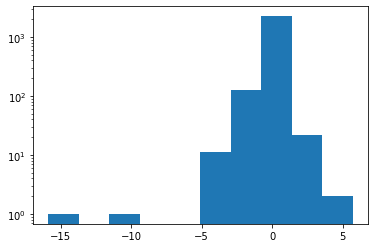

In [14]:
plt.hist(sharpes_df.sharpe)
plt.yscale('log');

In [15]:
sharpes.loc[sharpes.stock == 'sfg', :]

,stock,sharpe


In [16]:
omit = 'dcue'
inds = []
for o in omit.split():
    inds += (sharpes.loc[sharpes.stock == o, :].index.tolist())

sharpes.drop(index=inds, inplace=True)

In [17]:
sharpes.to_csv('sharpes.csv', index=False)

In [18]:
sharpes.shape

(2652, 2)

In [19]:
MIX = sharpes.stock.unique().tolist()[:400]
len(MIX)
df = yf.download(MIX, start=START, end=TODAY)
df.drop(
    columns=['Open', 'Close', 'Volume', 'High', 'Low'], inplace=True)
print(df.shape)
df.head()

[*********************100%***********************]  400 of 400 completed
(2516, 400)


Adj Close                                                     \
                  ABC      ABEV        ABM ACA      ACRE ADCT        ADM   
Date                                                                       
2012-08-27  32.373737  4.428823  16.572758 NaN  6.925341  NaN  20.142521   
2012-08-28  31.998293  4.427359  16.524017 NaN  6.988839  NaN  20.104399   
2012-08-29  32.126293  4.360012  16.540266 NaN  7.031170  NaN  20.264511   
2012-08-30  32.510258  4.414183  16.394033 NaN  7.052336  NaN  20.226391   
2012-08-31  32.868641  4.534235  16.426533 NaN  7.128532  NaN  20.394115   

                                            ...                            \
                 AEG        AEL        AEO  ... WDH       WLYB        WMT   
Date                                        ...                             
2012-08-27  3.326904  10.468036  15.334778  ... NaN  37.178295  57.962399   
2012-08-28  3.352644  10.540730  15.383640  ... NaN  37.349625  57.890446   
2012-08-29  3.326904  10.522557  15.613978  ... NaN  38.260769  58.178246   
2012-08-30  3.223943  10.477122  15.565119  ... NaN  38.105015  57.762531   
2012-08-31  3.294728  10.504384  15.523238  ... NaN  38.362019  58.042332   

                                                                
           WNNR WPCA        WRE        WSO        XOM XPOA YOU  
Date                                                            
2012-08-27  NaN  NaN  17.372667  52.407314  57.550404  NaN NaN  
2012-08-28  NaN  NaN  17.353184  52.688080  57.786533  NaN NaN  
2012-08-29  NaN  NaN  17.398649  52.884617  57.655376  NaN NaN  
2012-08-30  NaN  NaN  17.424629  52.674038  57.196190  NaN NaN  
2012-08-31  NaN  NaN  17.444105  52.968872  57.261784  NaN NaN  

[5 rows x 400 columns]

In [20]:
df.columns = MIX
MAX_MISSING = 30
n_nan = df.isnull().sum()
n_nan
drop = n_nan[n_nan > MAX_MISSING].index
df = df.drop(columns=drop)
print(df.shape)
df.head()

(2516, 230)


,ASAN,efc,stry,eve,hhs,bxsl,dwin,swi,pnw,irs,...,hr,mixt,thr,tinv,ohi,jbgs,cni,rcc,cah,tslx
Date,,,,,,,,,,,,,,,,,,,,,
2012-08-27,32.373737,4.428823,16.572758,6.925341,20.142521,3.326904,10.468036,15.334778,19.129023,5.102514,...,29.761364,7.614138,8.216013,37.450855,11.517503,37.178295,57.962399,17.372667,52.407314,57.550404
2012-08-28,31.998293,4.427359,16.524017,6.988839,20.104399,3.352644,10.540730,15.383640,19.019373,5.102514,...,29.700748,7.566091,8.207456,37.307980,11.689539,37.349625,57.890446,17.353184,52.688080,57.786533
2012-08-29,32.126293,4.360012,16.540266,7.031170,20.264511,3.326904,10.522557,15.613978,18.630615,5.049363,...,29.845291,7.526774,8.267365,37.303219,11.698595,38.260769,58.178246,17.398649,52.884617,57.655376
2012-08-30,32.510258,4.414183,16.394033,7.052336,20.226391,3.223943,10.477122,15.565119,18.421282,5.067081,...,29.537556,7.509297,8.053404,37.179398,11.771034,38.105015,57.762531,17.424629,52.674038,57.196190
2012-08-31,32.868641,4.534235,16.426533,7.128532,20.394115,3.294728,10.504384,15.523238,19.667309,5.146809,...,29.898903,7.478720,8.181784,37.212742,11.970236,38.362019,58.042332,17.444105,52.968872,57.261784


In [21]:
#import cvxpy
#cvxpy.installed_solvers()

In [22]:
mu = mean_historical_return(df)
s = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, s, solver='ECOS')# , verbose=True)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

fmc   : 0.01802
hrl   : 0.01352
sxt   : 0.05154
rad   : 0.00656
trv   : 0.04676
mov   : 0.02996
crhc  : 0.03396
hmn   : 0.10871
kar   : 0.01204
fif   : 0.07822
eqgp  : 0.01545
dma   : 0.10028
renx  : 0.18266
msge  : 0.12321
gcv   : 0.12288
rc    : 0.04372
cah   : 0.01253


In [23]:
ret, vol, sh = ef.portfolio_performance(verbose=True)

Expected annual return: 22.1%
Annual volatility: 13.0%
Sharpe Ratio: 1.54


In [24]:
ret, sh

(0.2211974308797632, 1.5421737153166932)

In [25]:
vol = np.linspace(0.10, 0.30, 50)
rets = []
sharpes = []
for v in vol:
    print(f'Vol: {v}   ', end='\r')
    ef = EfficientFrontier(mu, s, solver='ECOS')
    w = ef.efficient_risk(target_volatility=v)
    r, _, sh = ef.portfolio_performance()
    rets.append(r)
    sharpes.append(sh)

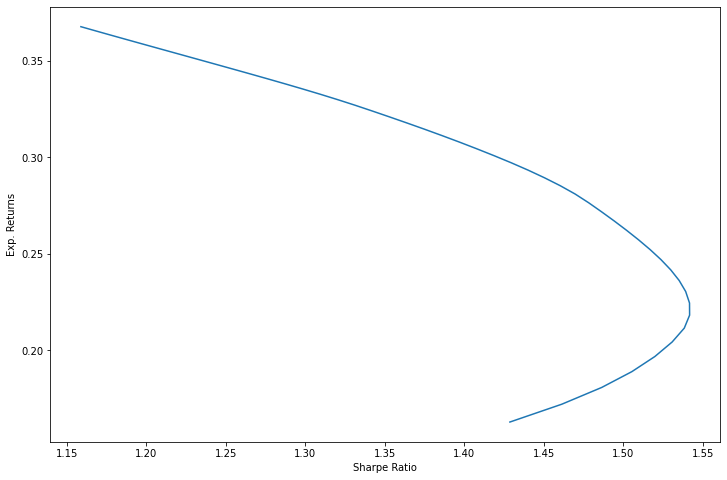

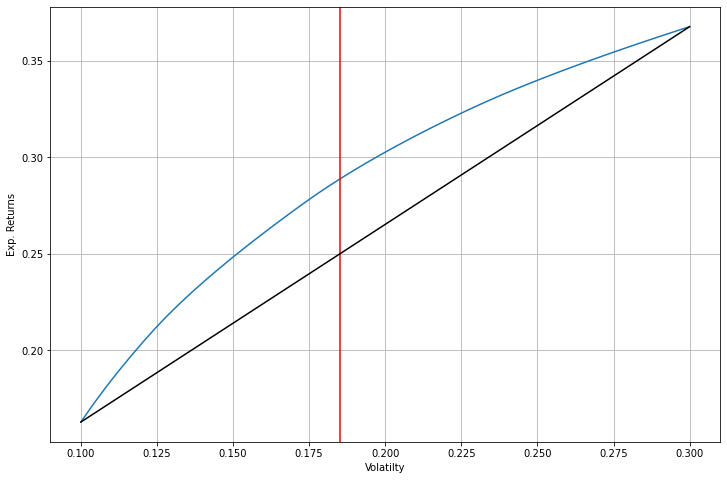

In [26]:
plt.figure(figsize=[12,8])
plt.plot(sharpes, rets)
plt.xlabel('Sharpe Ratio')
plt.ylabel('Exp. Returns');

plt.figure(figsize=[12,8])
plt.plot(vol, rets)
plt.grid(True)
plt.axvline(x=0.185, color='r')
plt.plot([0.1, 0.3], [rets[0], rets[-1]], color='k')
plt.xlabel('Volatilty')
plt.ylabel('Exp. Returns');

In [27]:
OPTIMAL_VOL = 0.185
ef = EfficientFrontier(mu, s, solver='ECOS')
weights = ef.efficient_risk(target_volatility=OPTIMAL_VOL)
cleaned_weights = dict(ef.clean_weights())
weights = {k: v for k, v in cleaned_weights.items() if v > 0}
for k, v in weights.items():
    print(f'{k:6s}: {v}')

fmc   : 0.04009
hrl   : 0.01212
sxt   : 0.04797
trv   : 0.00615
hmn   : 0.166
kar   : 0.01679
fif   : 0.09535
eqgp  : 0.05524
dma   : 0.05906
msge  : 0.21799
gcv   : 0.24585
rc    : 0.03739


In [28]:
ret, vol, sh = ef.portfolio_performance(verbose=True)

Expected annual return: 28.9%
Annual volatility: 18.5%
Sharpe Ratio: 1.45


In [29]:
ret, sh

(0.2886787428756675, 1.4523175295299982)

In [30]:
sharpes_df.loc[weights.keys(), 'sharpe']

stock
fmc     1.546894
hrl     1.320501
sxt     0.992081
trv     0.913207
hmn     0.770981
kar     0.766604
fif     0.740030
eqgp    0.735395
dma     0.695828
msge    0.664737
gcv     0.663361
rc      0.660977
Name: sharpe, dtype: float64